In [4]:
gpu = "0" #iF YOU WANT TO USE GPU
# gpu = None 

import os
import torch
#----------------------------------------------------------------
# Selecting the device
#----------------------------------------------------------------
if gpu:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = '0' #aca se pone nuemro de grafica libre

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
    print('CUDA Visible devices:',os.getenv('CUDA_VISIBLE_DEVICES'))
else:
    device = torch.device('cpu')
    print("Failed to find GPU, using CPU instead.")


Using GPU: Tesla T4
CUDA Visible devices: 0


In [1]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import tensorboard as tb
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import shutil
import numpy as np

#others
from tqdm.notebook import tqdm

In [2]:
class ejemplo_CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=5):
     super(ejemplo_CNN, self).__init__()
     self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=2, stride=2, padding=0)
     self.aveg = nn.AvgPool2d(kernel_size=3 ,stride=1)
     self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
     self.max = nn.MaxPool2d(kernel_size=2, stride=2)
     self.fc1 = nn.Linear(6 * 5 * 5, num_classes)

    def forward(self, x):
      x = F.leaky_relu(self.conv1(x))
      x = self.aveg(x)
      x = F.relu6(self.conv2(x))
      x = self.max(x)
      #print(x.shape)
      x = x.reshape(x.shape[0], -1)
      #print(x.shape)
      x = self.fc1(x)
      return x

In [5]:
model = ejemplo_CNN().to(device)
print(model)

ejemplo_CNN(
  (conv1): Conv2d(1, 3, kernel_size=(2, 2), stride=(2, 2))
  (aveg): AvgPool2d(kernel_size=3, stride=1, padding=0)
  (conv2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=150, out_features=5, bias=True)
)


In [7]:
model = ejemplo_CNN(in_channels=1, num_classes=10)
model.to(device) #move model to device
model(torch.ones((1,1,28,28)).to(device))

tensor([[ 0.4004, -0.0592,  0.0584, -0.2774, -0.1639,  0.2439, -0.3493,  0.0122,
          0.0158,  0.2118]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [8]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [9]:
print(f"Amount of training data: {len(training_data.targets)}, and test data: {len(test_data.targets)}")

Amount of training data: 60000, and test data: 10000


In [10]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def training(model, dataloader, loss_fn, optimizer):
  size = len(dataloader.dataset)#actual dataset size
  model.train()
  for batch_id, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    #getting the class predictions
    pred = model(X)
    #computing the loss
    loss = loss_fn(pred, y)

    # weights update
    optimizer.zero_grad() # to "clean" the gradients memory
    loss.backward() # chain rule 
    optimizer.step() # weights updating

    if batch_id % 100 == 0:
      loss, current_sample = loss.item(), batch_id*len(X)
      print(f"loss: {loss:>3f} [{current_sample:>5d}/{size:>5d}]")

In [13]:
def test(model, dataloader, loss_fn):
  size = len(dataloader.dataset)#amount of available data
  num_batches = len(dataloader) 
  model.eval()#avoid the model learning
  test_loss, correct = 0, 0
  # no gradients calculation
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      #get the predictions
      pred = model(X)
      #computing the loss 
      test_loss += loss_fn(pred, y).item() #Returns the value of this tensor as a standard Python number
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  correct /= size
  acc = 100*correct
  print(f"Test error: \n Acc: {(acc):>0.1f}%, avg loss: {test_loss:>8f}\n")
  return acc, test_loss


In [24]:
epochs = 20
a = []
b = []

for i in range(epochs):
  print(f"Epoch {i+1}\n ---------------------------")
  training(model, train_dataloader, loss_fn, optimizer)
  acc, loss = test(model, test_dataloader, loss_fn) 
  a.append(acc), b.append(loss)

print("done")


Epoch 1
 ---------------------------
loss: 2.304907 [    0/60000]
loss: 2.298499 [ 6400/60000]
loss: 2.310118 [12800/60000]
loss: 2.304029 [19200/60000]
loss: 2.308971 [25600/60000]
loss: 2.311353 [32000/60000]
loss: 2.316414 [38400/60000]
loss: 2.301121 [44800/60000]
loss: 2.308789 [51200/60000]
loss: 2.315807 [57600/60000]
Test error: 
 Acc: 10.3%, avg loss: 2.303876

Epoch 2
 ---------------------------
loss: 2.299389 [    0/60000]
loss: 2.297312 [ 6400/60000]
loss: 2.304970 [12800/60000]
loss: 2.300743 [19200/60000]
loss: 2.308245 [25600/60000]
loss: 2.307505 [32000/60000]
loss: 2.305074 [38400/60000]
loss: 2.305579 [44800/60000]
loss: 2.306163 [51200/60000]
loss: 2.303501 [57600/60000]
Test error: 
 Acc: 8.6%, avg loss: 2.301384

Epoch 3
 ---------------------------
loss: 2.297592 [    0/60000]
loss: 2.297520 [ 6400/60000]
loss: 2.303024 [12800/60000]
loss: 2.299223 [19200/60000]
loss: 2.308039 [25600/60000]
loss: 2.305701 [32000/60000]


KeyboardInterrupt: ignored

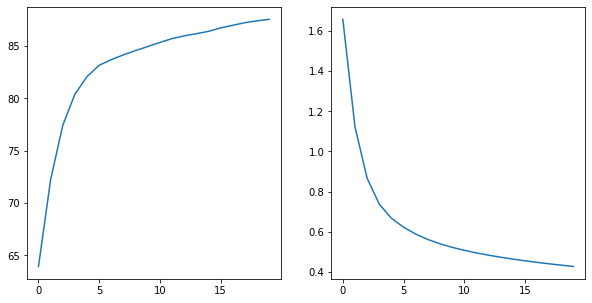

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].plot(a)
axs[1].plot(b)


# Early stopping

Early Stopping is an optimisation technique done by **calculating the Validation loss**. If the validation loss does not decrease over a specified number of iterations the model halts its training. 

In [32]:
# Hyper-parameters
batch_size = 64
lr = 0.01
num_epochs = 100 

# Data
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Model, optim, ...
model = ejemplo_CNN(in_channels=1, num_classes=10)
model.to(device) #move model to device


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [33]:
min_val_loss = np.inf
num_noImprove_stop = 5
early_stop = False


for epoch in range(num_epochs):
  val_loss = 0
  print(f"Epoch {epoch+1}\n ---------------------------")
  training(model, train_dataloader, loss_fn, optimizer)

  # Validation
  model.eval()#avoid the model learning
  with torch.no_grad():
    val_loss, correct = 0, 0
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      #get the predictions
      pred = model(X)
      loss = loss_fn(pred, y).item()
      val_loss += loss
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    
    val_loss = val_loss / len(test_dataloader)
    acc = 100*(correct / len(test_dataloader.dataset))
    print(f"Test error: \n Acc: {(acc):>0.1f}%, avg loss: {val_loss:>8f}\n")

    if val_loss < min_val_loss:
      print(f"---> Previous loss {min_val_loss} | Current loss {val_loss}")
      epoch_no_improve = 0
      min_val_loss = val_loss
    else:
      print(f"Epoch {epoch+1} (No improve) -- {epoch_no_improve}")
      epoch_no_improve += 1

    if epoch_no_improve == num_noImprove_stop:
      print("Early stopping!")
      early_stop = True
      break
    else:
      continue



Epoch 1
 ---------------------------
loss: 2.290553 [    0/60000]
loss: 2.290601 [ 6400/60000]
loss: 2.305322 [12800/60000]
loss: 2.286088 [19200/60000]
loss: 2.282165 [25600/60000]
loss: 2.239641 [32000/60000]
loss: 2.110383 [38400/60000]
loss: 1.997742 [44800/60000]
loss: 1.419011 [51200/60000]
loss: 0.926875 [57600/60000]
Test error: 
 Acc: 75.0%, avg loss: 0.836386

---> Previous loss inf | Current loss 0.8363855858896948
Epoch 2
 ---------------------------
loss: 0.877746 [    0/60000]
loss: 0.536913 [ 6400/60000]
loss: 0.530657 [12800/60000]
loss: 0.563638 [19200/60000]
loss: 0.503934 [25600/60000]
loss: 0.527566 [32000/60000]
loss: 0.422420 [38400/60000]
loss: 0.586158 [44800/60000]
loss: 0.643128 [51200/60000]
loss: 0.563203 [57600/60000]
Test error: 
 Acc: 84.5%, avg loss: 0.485977

---> Previous loss 0.8363855858896948 | Current loss 0.4859769793737466
Epoch 3
 ---------------------------
loss: 0.493881 [    0/60000]
loss: 0.377126 [ 6400/60000]
loss: 0.335172 [12800/60000]
l

In [34]:
epoch_no_improve

0